In [1]:
#Logistic Regression
import os
import pandas as pd
import numpy as np

import chart_studio.plotly as py
import cufflinks as cf
import seaborn as sns
import matplotlib
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

cf.go_offline()
import plotly.io as pio
pio.renderers.default = "iframe_connected"

In [2]:
#Default styles for chart
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows',150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [3]:
raw_df = pd.read_csv('weatherAUS.csv')

In [4]:
raw_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [6]:
raw_df.dropna(subset=['RainTomorrow'], inplace=True)

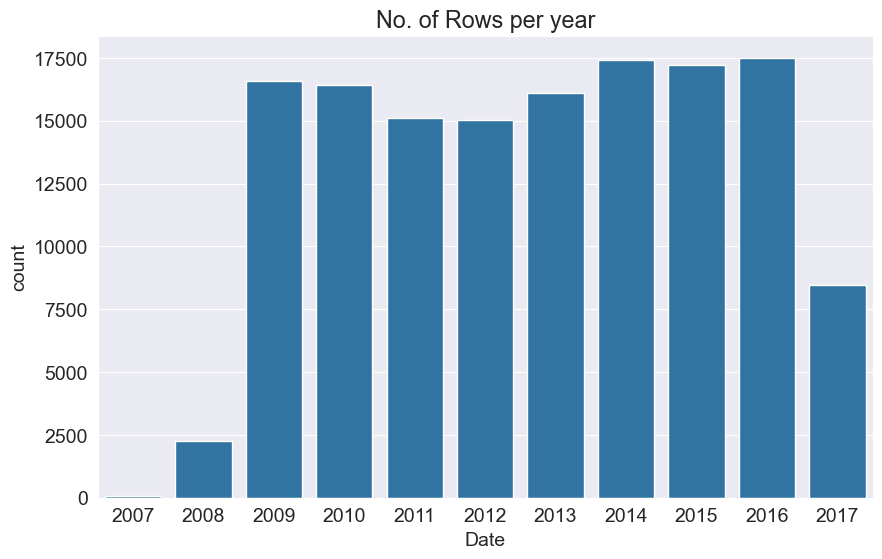

In [7]:
plt.title('No. of Rows per year')
sns.countplot(x=pd.to_datetime(raw_df.Date).dt.year);

In [8]:
year = pd.to_datetime(raw_df.Date).dt.year

train_df = raw_df[year < 2015]
val_df = raw_df[year == 2015]
test_df = raw_df[year > 2015]

In [9]:
print('train_df.shape :',train_df.shape)
print('val_df.shape :',val_df.shape)
print('test_df.shape :',test_df.shape)

train_df.shape : (98988, 23)
val_df.shape : (17231, 23)
test_df.shape : (25974, 23)


In [10]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'

train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

In [11]:
numeric_cols = train_inputs.select_dtypes(include = np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

print(categorical_cols)

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


In [12]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'mean').fit(raw_df[numeric_cols])

In [13]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

In [14]:
train_inputs[numeric_cols].isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

In [15]:
val_inputs.describe().loc[['min','max']]

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
min,-8.2,-3.2,0.0,0.0,0.0,7.0,0.0,0.0,4.0,0.0,988.1,982.2,0.0,0.0,-6.2,-4.0
max,31.9,45.4,247.2,70.4,14.5,135.0,87.0,74.0,100.0,100.0,1039.3,1037.3,8.0,8.0,37.5,42.8


In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(raw_df[numeric_cols])

In [17]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [18]:
train_inputs.describe().loc[['min','max']]

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
min,0.0,0.013233,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0304,0.0,0.0,0.027426,0.005758
max,1.0,1.000000,1.0,0.568276,0.986207,1.0,0.669231,1.0,1.0,1.0,1.0,1.0000,1.0,1.0,1.000000,0.988484


In [19]:
from sklearn.preprocessing import OneHotEncoder


train_inputs[categorical_cols] = train_df[categorical_cols].fillna('Unknown')
val_inputs[categorical_cols] =val_df[categorical_cols].fillna('Unknown')
test_inputs[categorical_cols] =test_df[categorical_cols].fillna('Unknown')

In [20]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(train_inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [21]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

C:\Users\MSI\AppData\Local\Temp\ipykernel_18100\1584174743.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\MSI\AppData\Local\Temp\ipykernel_18100\1584174743.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\MSI\AppData\Local\Temp\ipykernel_18100\1584174743.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame,

In [22]:
test_inputs

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_Unknown,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_Unknown,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_Unknown,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_No,RainToday_Unknown,RainToday_Yes
2498,Albury,0.681604,0.801512,0.000000,0.037723,0.525852,ENE,0.372093,Unknown,ESE,0.000000,0.080460,0.46,0.17,0.543802,0.5136,0.777778,0.333333,0.702532,0.808061,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2499,Albury,0.693396,0.725898,0.001078,0.037723,0.525852,SSE,0.341085,SSE,SE,0.069231,0.195402,0.54,0.30,0.505785,0.5008,0.888889,0.888889,0.675105,0.712092,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2500,Albury,0.634434,0.527410,0.005930,0.037723,0.525852,ENE,0.325581,ESE,ENE,0.084615,0.448276,0.62,0.67,0.553719,0.6032,0.888889,0.888889,0.611814,0.477927,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2501,Albury,0.608491,0.538752,0.042049,0.037723,0.525852,SSE,0.255814,SE,SSE,0.069231,0.195402,0.74,0.65,0.618182,0.6304,0.888889,0.888889,0.556962,0.518234,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [23]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [24]:
train_targets

0         No
1         No
2         No
3         No
4         No
          ..
144548    No
144549    No
144550    No
144551    No
144552    No
Name: RainTomorrow, Length: 98988, dtype: object

In [25]:
X_test

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_Unknown,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_Unknown,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_Unknown,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_No,RainToday_Unknown,RainToday_Yes
2498,0.681604,0.801512,0.000000,0.037723,0.525852,0.372093,0.000000,0.080460,0.46,0.17,0.543802,0.5136,0.777778,0.333333,0.702532,0.808061,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2499,0.693396,0.725898,0.001078,0.037723,0.525852,0.341085,0.069231,0.195402,0.54,0.30,0.505785,0.5008,0.888889,0.888889,0.675105,0.712092,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2500,0.634434,0.527410,0.005930,0.037723,0.525852,0.325581,0.084615,0.448276,0.62,0.67,0.553719,0.6032,0.888889,0.888889,0.611814,0.477927,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2501,0.608491,0.538752,0.042049,0.037723,0.525852,0.255814,0.069231,0.195402,0.74,0.65,0.618182,0.6304,0.888889,0.888889,0.556962,0.518234,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.

In [26]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, train_targets)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [27]:
train_preds = model.predict(X_train)

In [28]:
 from sklearn.metrics import accuracy_score, confusion_matrix

In [29]:
pd.value_counts(train_preds)

C:\Users\MSI\AppData\Local\Temp\ipykernel_18100\1258350197.py:1: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.



No     76707
Yes    22281
Name: count, dtype: int64

In [30]:
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [31]:
accuracy_score(train_preds, train_targets)

0.9999797955307714

In [32]:
train_probs = model.predict_proba(X_train)
train_probs


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [33]:
model.score(X_val,val_targets)

0.7928152747954268

[Text(0.5, 0.9166666666666666, 'Humidity3pm <= 0.715\ngini = 0.349\nsamples = 98988\nvalue = [76705, 22283]'),
 Text(0.25, 0.75, 'Rainfall <= 0.004\ngini = 0.248\nsamples = 82418\nvalue = [70439.0, 11979.0]'),
 Text(0.375, 0.8333333333333333, 'True  '),
 Text(0.125, 0.5833333333333334, 'Sunshine <= 0.525\ngini = 0.198\nsamples = 69252\nvalue = [61538.0, 7714.0]'),
 Text(0.0625, 0.4166666666666667, 'Pressure3pm <= 0.583\ngini = 0.363\nsamples = 12620\nvalue = [9618, 3002]'),
 Text(0.03125, 0.25, 'WindGustSpeed <= 0.364\ngini = 0.469\nsamples = 4691\nvalue = [2932, 1759]'),
 Text(0.015625, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.046875, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.09375, 0.25, 'Pressure3pm <= 0.698\ngini = 0.264\nsamples = 7929\nvalue = [6686, 1243]'),
 Text(0.078125, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.109375, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.1875, 0.4166666666666667, 'Humidity3pm <= 0.512\ngini = 0.153\nsamples = 56632\nvalue = [51920,

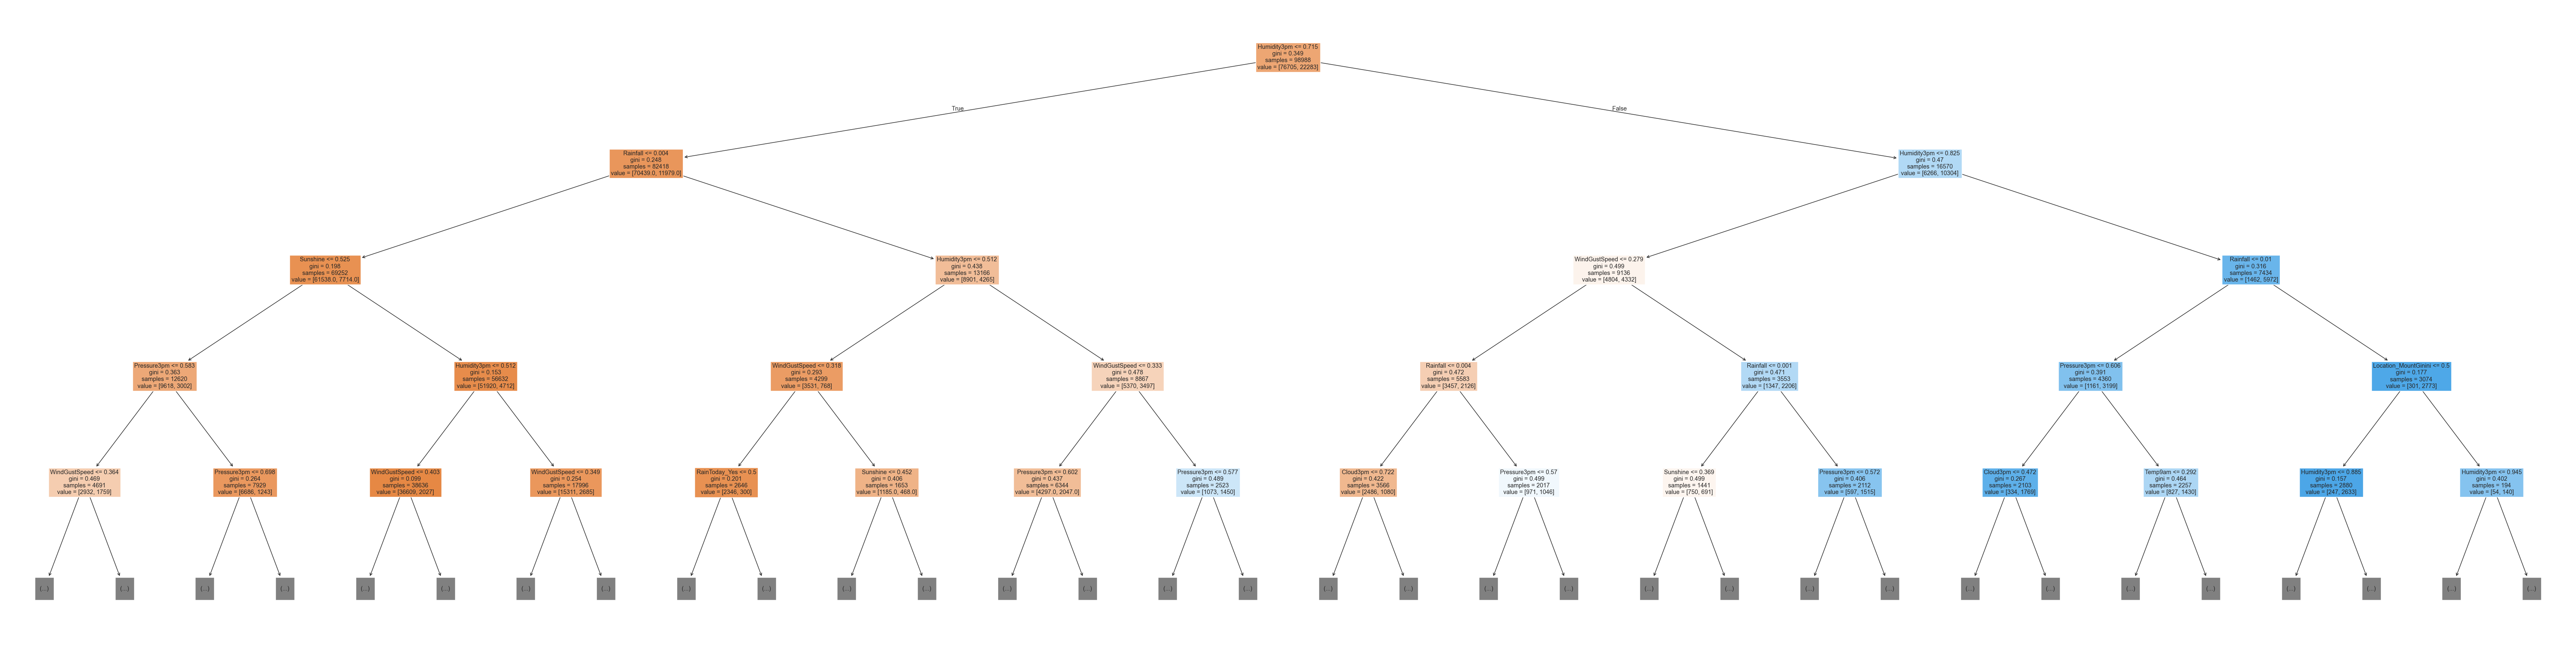

In [34]:
from sklearn.tree import plot_tree, export_text

plt.figure(figsize=(80,20))
plot_tree(model, feature_names = X_train.columns, max_depth = 4, filled = True )

In [35]:
 model.tree_.max_depth

48

In [36]:
tree_text = export_text(model,max_depth=10, feature_names=list(X_train.columns))
print(tree_text[:5000])

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- WindDir9am_NE <= 0.50
|   |   |   |   |   |   |   |--- Location_Watsonia <= 0.50
|   |   |   |   |   |   |   |   |--- Cloud9am <= 0.83
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm <= 0.07
|   |   |   |   |   |   |   |   |   |   |--- Pressure9am <= 0.47
|   |   |   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |   |   |   |--- Pressure9am >  0.47
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm >  0.07
|   |   |   |   |   |   |   |   |   |   |--- MinTemp <= 0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- MinTemp >  0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated

In [37]:
model.feature_importances_

array([3.43949832e-02, 3.20723744e-02, 5.96978427e-02, 2.39997157e-02,
       4.96970278e-02, 5.52776844e-02, 2.77290154e-02, 2.87896517e-02,
       3.97762378e-02, 2.61665505e-01, 3.38797443e-02, 6.29086081e-02,
       1.41634157e-02, 1.82574107e-02, 3.39304134e-02, 2.99978180e-02,
       2.29983521e-03, 1.97127428e-03, 1.30448300e-03, 7.05458133e-04,
       1.51355792e-03, 1.12862805e-03, 8.66864394e-04, 1.77451768e-03,
       1.21677026e-03, 1.57331930e-03, 8.42954495e-04, 2.05031388e-03,
       1.90637772e-03, 3.26731137e-04, 1.11629763e-03, 1.52431517e-03,
       5.08479231e-04, 8.30004101e-04, 1.48248394e-03, 8.87667861e-04,
       7.61612213e-04, 7.02994607e-04, 1.72668316e-03, 2.07806756e-03,
       3.80229195e-04, 7.64016199e-04, 1.38715756e-03, 1.47491895e-03,
       1.48825382e-03, 8.67028594e-04, 8.33784178e-04, 1.54580309e-03,
       1.09367536e-03, 2.03218887e-03, 8.51581460e-04, 1.79979059e-03,
       9.69639078e-04, 1.28254100e-03, 1.28721925e-03, 3.77018000e-04,
      

In [38]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance':model.feature_importances_
}).sort_values('importance',ascending=False)

In [39]:
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.261666
11,Pressure3pm,0.062909
2,Rainfall,0.059698
5,WindGustSpeed,0.055278
4,Sunshine,0.049697
8,Humidity9am,0.039776
0,MinTemp,0.034395
14,Temp9am,0.033930
10,Pressure9am,0.033880
1,MaxTemp,0.032072


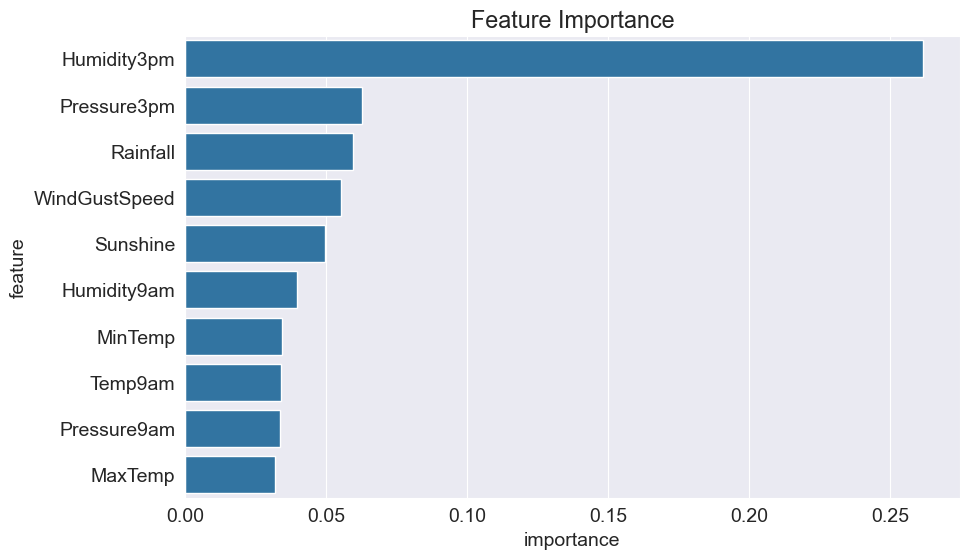

In [40]:
plt.title("Feature Importance")
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

In [41]:
model = DecisionTreeClassifier(max_depth = 3, random_state = 42)

In [42]:
model.fit(X_train, train_targets)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [43]:
model.score(X_train, train_targets)

0.8291308037337859

In [44]:
model.score(X_val, val_targets)

0.8334397307178921

In [45]:
model.classes_

array(['No', 'Yes'], dtype=object)

[Text(0.5, 0.875, 'Humidity3pm <= 0.715\ngini = 0.349\nsamples = 98988\nvalue = [76705, 22283]\nclass = No'),
 Text(0.25, 0.625, 'Rainfall <= 0.004\ngini = 0.248\nsamples = 82418\nvalue = [70439.0, 11979.0]\nclass = No'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'Sunshine <= 0.525\ngini = 0.198\nsamples = 69252\nvalue = [61538.0, 7714.0]\nclass = No'),
 Text(0.0625, 0.125, 'gini = 0.363\nsamples = 12620\nvalue = [9618, 3002]\nclass = No'),
 Text(0.1875, 0.125, 'gini = 0.153\nsamples = 56632\nvalue = [51920, 4712]\nclass = No'),
 Text(0.375, 0.375, 'Humidity3pm <= 0.512\ngini = 0.438\nsamples = 13166\nvalue = [8901, 4265]\nclass = No'),
 Text(0.3125, 0.125, 'gini = 0.293\nsamples = 4299\nvalue = [3531, 768]\nclass = No'),
 Text(0.4375, 0.125, 'gini = 0.478\nsamples = 8867\nvalue = [5370, 3497]\nclass = No'),
 Text(0.75, 0.625, 'Humidity3pm <= 0.825\ngini = 0.47\nsamples = 16570\nvalue = [6266, 10304]\nclass = Yes'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'WindGustSp

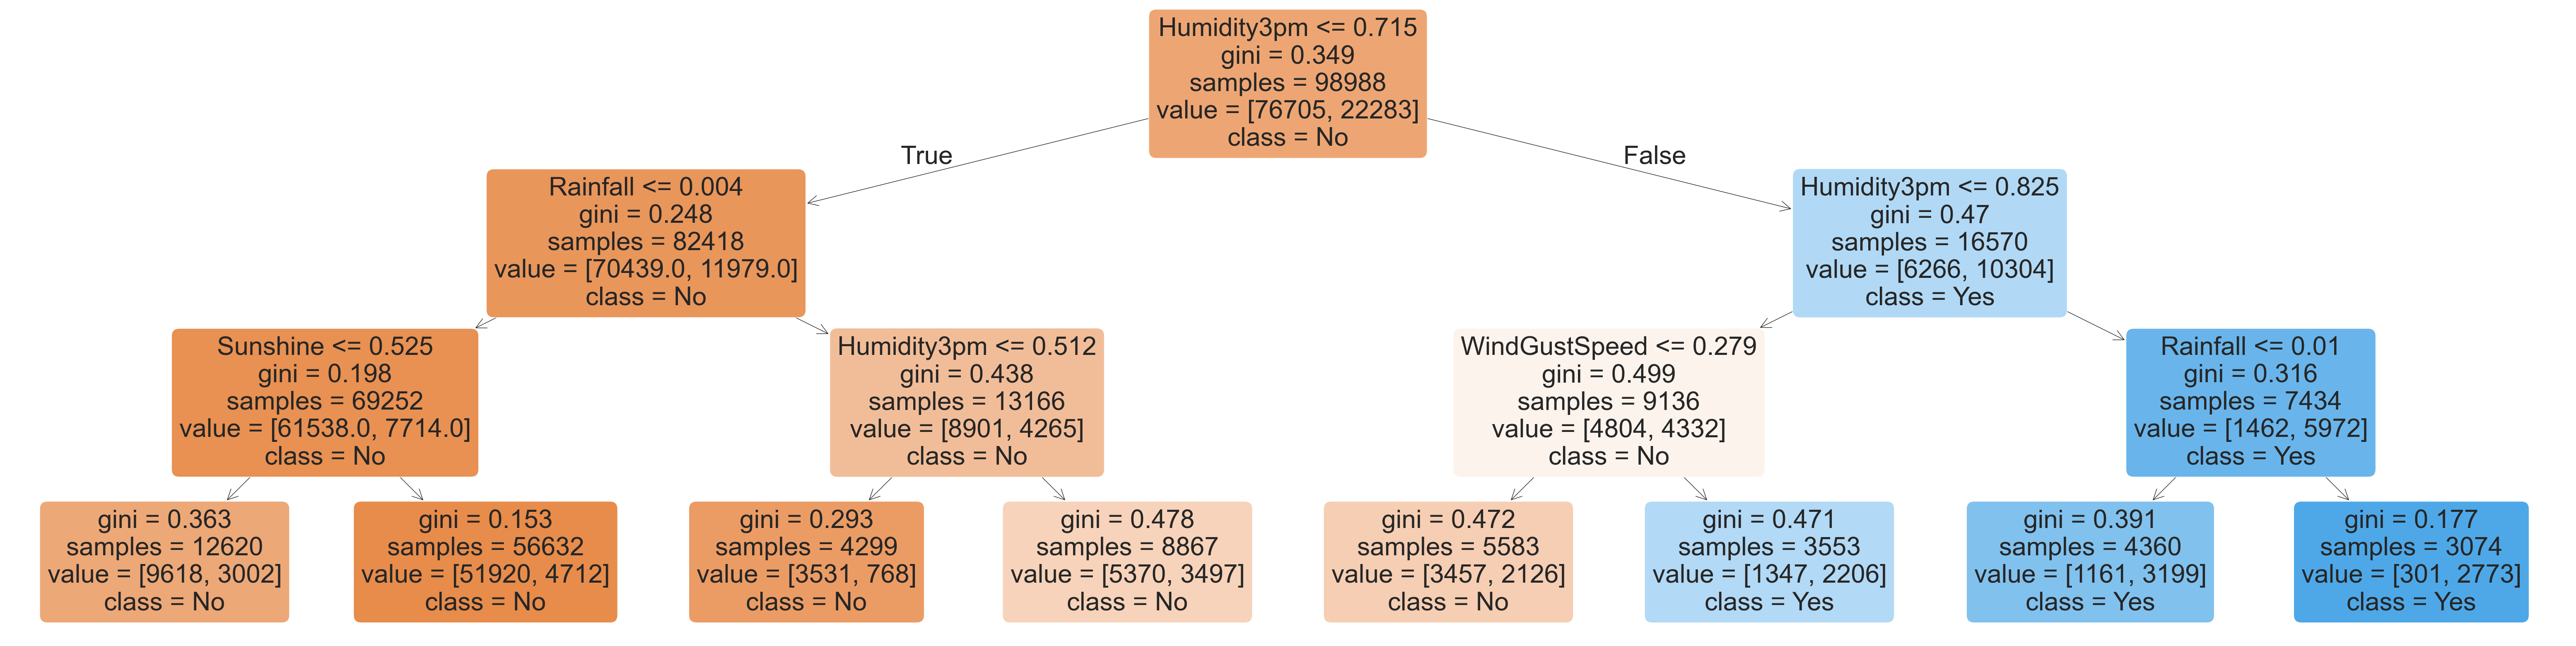

In [46]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names = X_train.columns,filled=True,rounded=True, class_names=model.classes_ )

In [47]:
print(export_text(model, feature_names=list(X_train.columns)))

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- class: No
|   |   |--- Sunshine >  0.52
|   |   |   |--- class: No
|   |--- Rainfall >  0.00
|   |   |--- Humidity3pm <= 0.51
|   |   |   |--- class: No
|   |   |--- Humidity3pm >  0.51
|   |   |   |--- class: No
|--- Humidity3pm >  0.72
|   |--- Humidity3pm <= 0.82
|   |   |--- WindGustSpeed <= 0.28
|   |   |   |--- class: No
|   |   |--- WindGustSpeed >  0.28
|   |   |   |--- class: Yes
|   |--- Humidity3pm >  0.82
|   |   |--- Rainfall <= 0.01
|   |   |   |--- class: Yes
|   |   |--- Rainfall >  0.01
|   |   |   |--- class: Yes



In [48]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, train_targets)
    train_acc = 1 - model.score(X_train, train_targets)
    val_acc = 1 - model.score(X_val,val_targets)
    return {'Max Depth': md, 'Training Error': train_acc, 'Validation Error': val_acc}

In [49]:
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1,21)])
errors_df

,Max Depth,Training Error,Validation Error
0,1,0.184315,0.177935
1,2,0.179547,0.172712
2,3,0.170869,0.166560
3,4,0.165707,0.164355
4,5,0.160676,0.159074
5,6,0.156271,0.157275
6,7,0.153312,0.154605
7,8,0.147806,0.157739
8,9,0.140916,0.156578
9,10,0.132966,0.157565


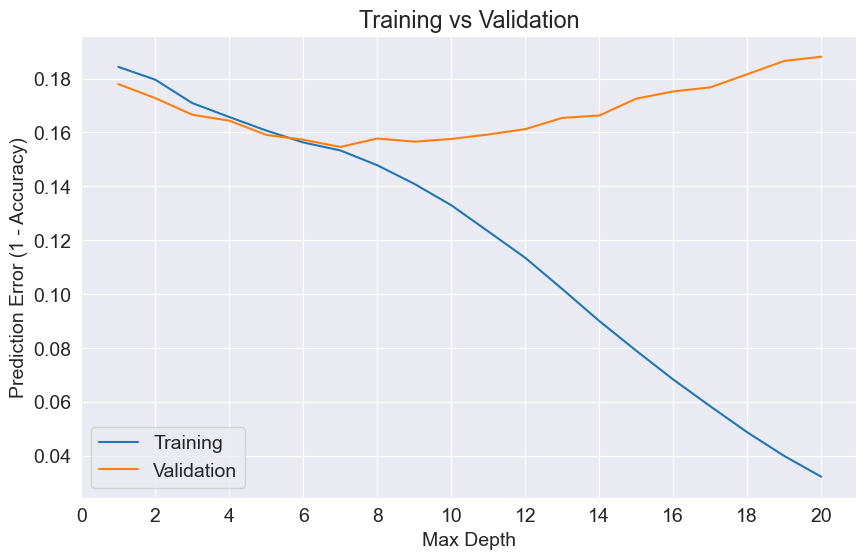

In [50]:
plt.figure()
plt.plot(errors_df['Max Depth'],errors_df['Training Error'])
plt.plot(errors_df['Max Depth'],errors_df['Validation Error'])
plt.title("Training vs Validation")
plt.xticks(range(0,21,2))
plt.xlabel('Max Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

In [51]:
model = DecisionTreeClassifier(max_depth = 7, random_state = 42).fit(X_train, train_targets)
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.8466884874934335, 0.8453949277465034)

In [52]:
model = DecisionTreeClassifier(max_leaf_nodes=128, random_state = 42)

In [53]:
model.fit(X_train, train_targets)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,128
,min_impurity_decrease,0.0
,class_weight,None


In [54]:
model.score(X_train, train_targets)

0.8480421869317493

In [55]:
model.score(X_val, val_targets)

0.8442342290058615

In [56]:
model.tree_.max_depth

12

In [57]:
model_text = export_text(model, feature_names=list(X_train.columns))
print(model_text[:3000])

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- Humidity3pm >  0.28
|   |   |   |   |   |   |--- Sunshine <= 0.05
|   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |--- Sunshine >  0.05
|   |   |   |   |   |   |   |--- Pressure3pm <= 0.43
|   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |--- Pressure3pm >  0.43
|   |   |   |   |   |   |   |   |--- Humidity3pm <= 0.57
|   |   |   |   |   |   |   |   |   |--- WindDir9am_NE <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- WindDir9am_NNE <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |   |--- WindDir9am_NNE >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |--- WindD

In [58]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs=-1,random_state=42)

In [59]:
%%time
model.fit(X_train, train_targets)

CPU times: total: 44.7 s
Wall time: 4.39 s


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [60]:
model.score(X_train,train_targets)

0.9999595910615429

In [61]:
model.score(X_val,val_targets)

0.8559572862863444

In [62]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.9 , 0.1 ],
       [0.97, 0.03],
       [0.99, 0.01],
       ...,
       [0.99, 0.01],
       [1.  , 0.  ],
       [0.95, 0.05]])

In [63]:
len(model.estimators_)

100

In [64]:
model.estimators_[0]

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,random_state,1608637542
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


[Text(0.5, 0.875, 'RainToday_Yes <= 0.5\ngini = 0.347\nsamples = 62607\nvalue = [76887, 22101]'),
 Text(0.25, 0.625, 'Cloud9am <= 0.611\ngini = 0.262\nsamples = 48769\nvalue = [65102, 11926]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'WindDir9am_E <= 0.5\ngini = 0.212\nsamples = 36906\nvalue = [51301, 7031]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'WindDir9am_N <= 0.5\ngini = 0.387\nsamples = 11863\nvalue = [13801.0, 4895.0]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'Pressure3pm <= 0.556\ngini = 0.497\nsamples = 13838\nvalue = [11785.0, 10175.0]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'Humidity9am <= 0.825\ngini = 0.482\nsamples = 5022\nvalue = [3250, 4755]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'Location_WaggaWagga <= 0.5\ngini = 0.475\nsamples = 8816\nvalue = [8535, 5420]'),
 Text(0.

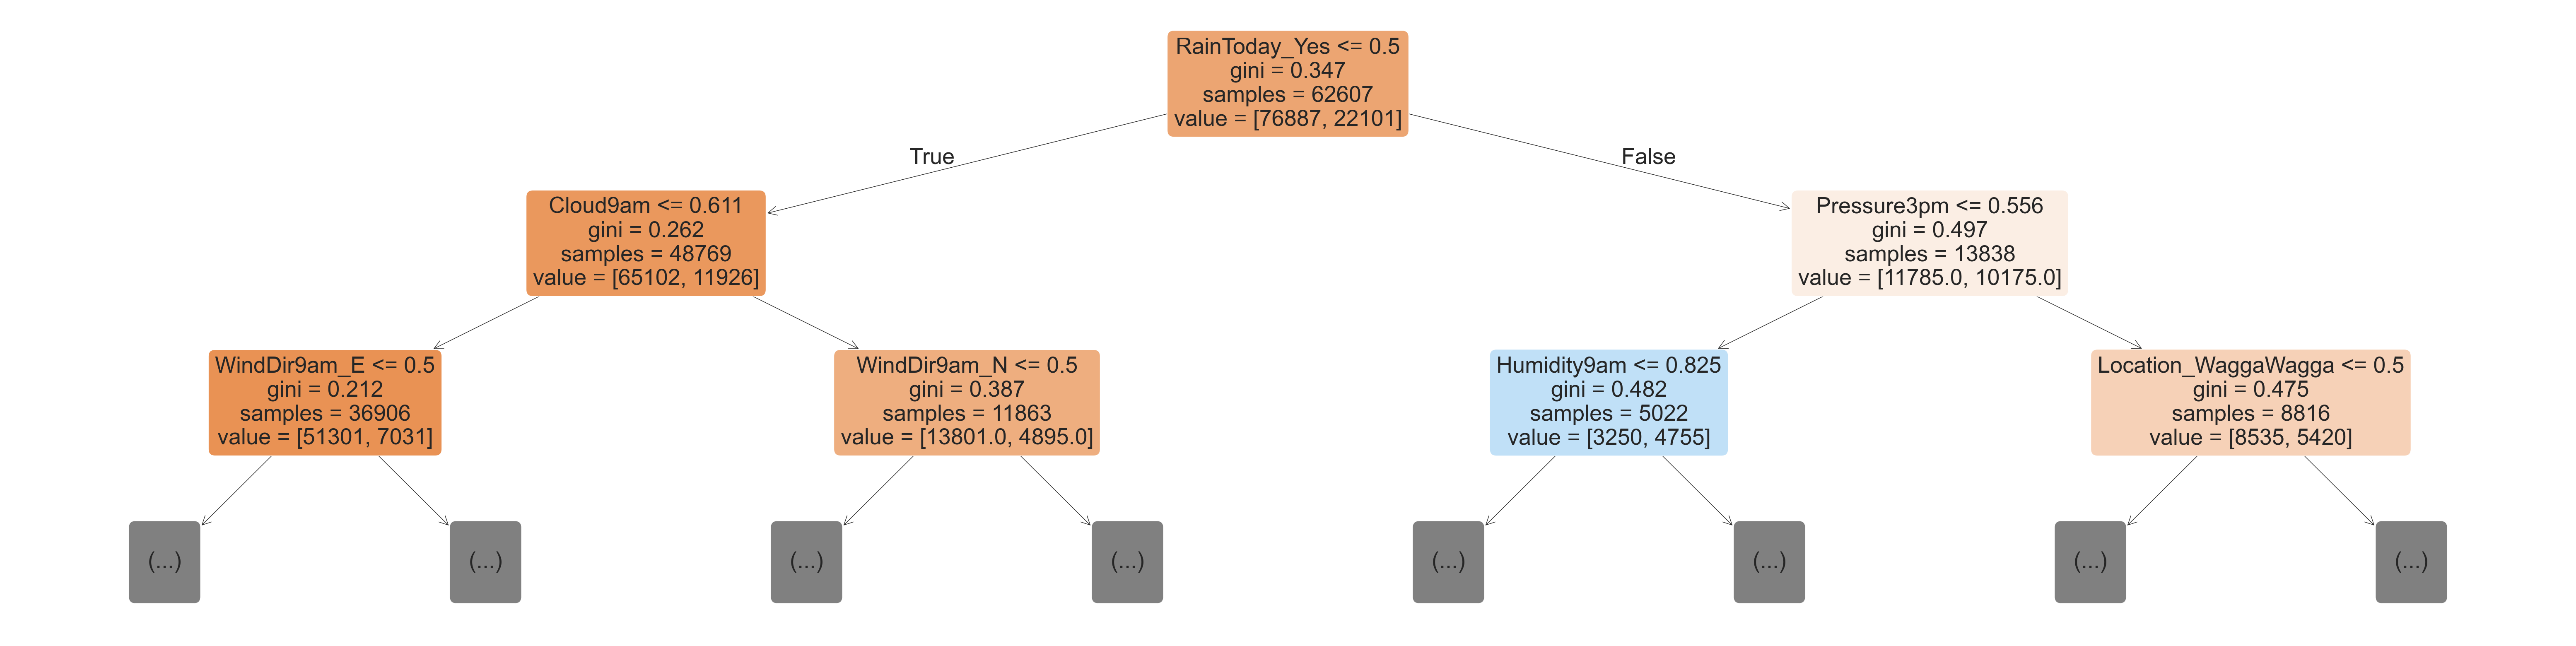

In [65]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[0], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True)

[Text(0.5, 0.875, 'RainToday_No <= 0.5\ngini = 0.351\nsamples = 62756\nvalue = [76554, 22434]'),
 Text(0.25, 0.625, 'Cloud3pm <= 0.833\ngini = 0.498\nsamples = 14498\nvalue = [12089, 10685]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'Humidity3pm <= 0.655\ngini = 0.488\nsamples = 12374\nvalue = [11189, 8220]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'WindSpeed3pm <= 0.414\ngini = 0.392\nsamples = 2124\nvalue = [900, 2465]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'WindGustDir_NNW <= 0.5\ngini = 0.261\nsamples = 48258\nvalue = [64465.0, 11749.0]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'Evaporation <= 0.021\ngini = 0.255\nsamples = 45976\nvalue = [61725, 10890]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'Cloud9am <= 0.722\ngini = 0.363\nsamples = 2282\nvalue = [2740, 859]'),
 Text(0.8125, 0.12

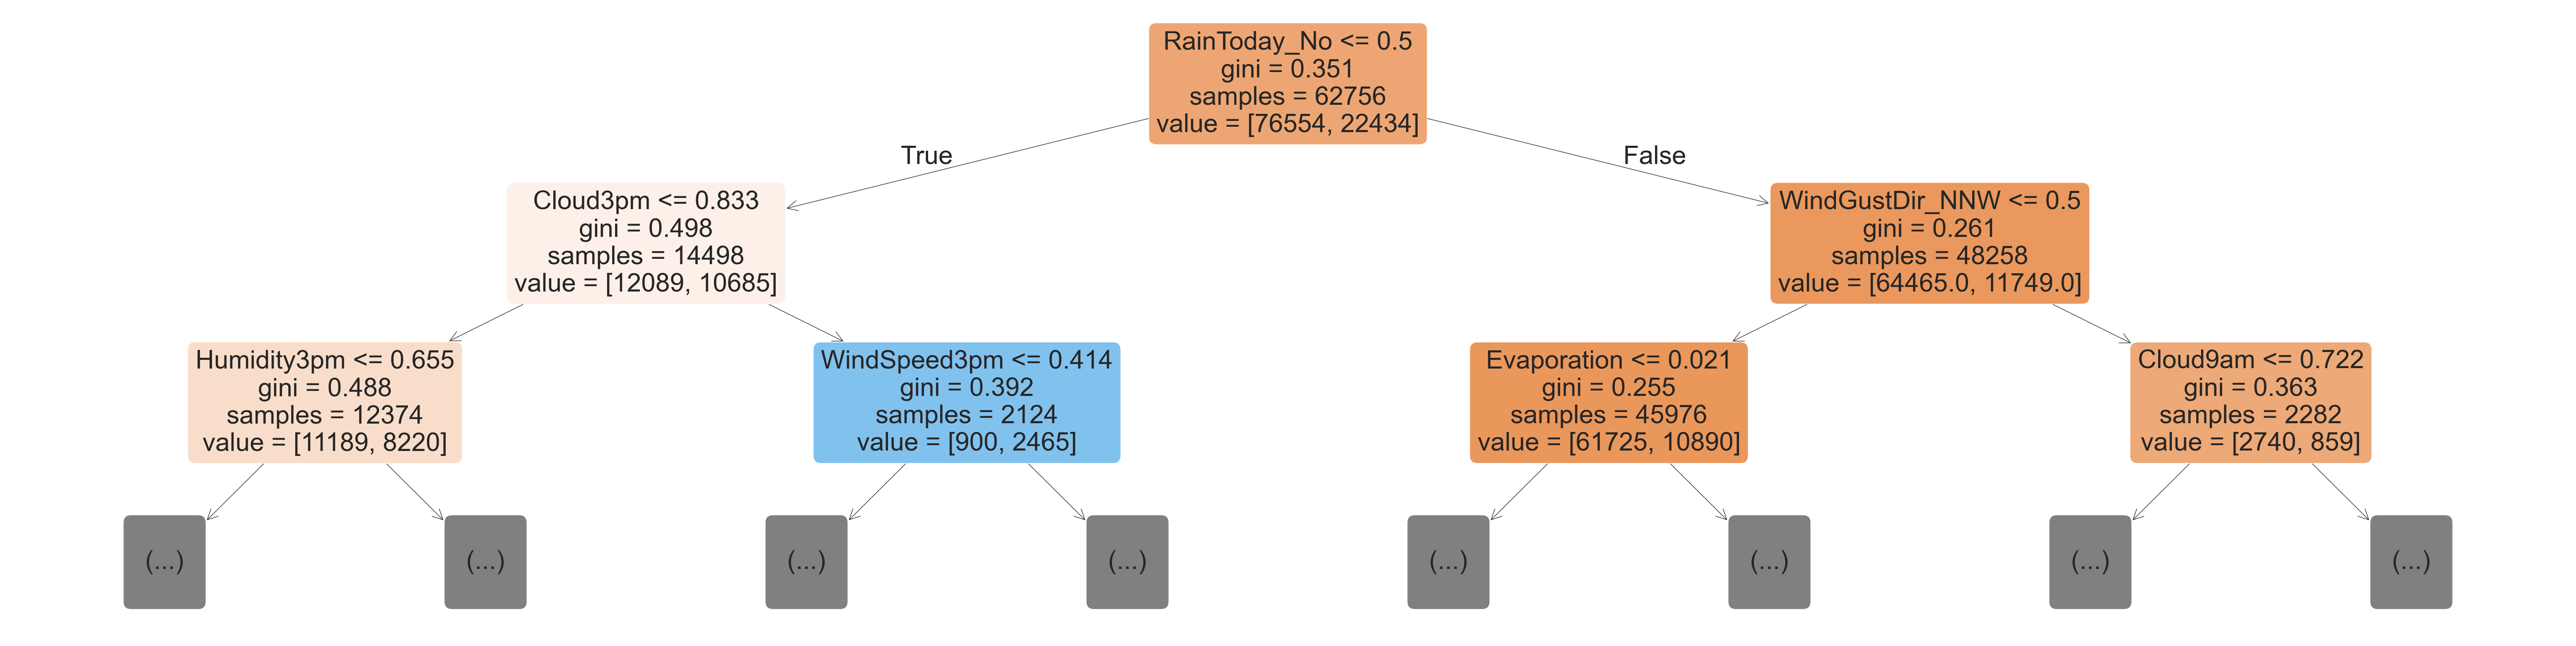

In [66]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[1], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True)

In [67]:
importance_df = pd.DataFrame({
    'feature':X_train.columns,
    'importance':model.feature_importances_
}).sort_values('importance', ascending=False)

In [68]:
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.133176
4,Sunshine,0.055553
11,Pressure3pm,0.052976
2,Rainfall,0.050488
10,Pressure9am,0.049379
8,Humidity9am,0.049261
5,WindGustSpeed,0.046640
15,Temp3pm,0.045179
1,MaxTemp,0.042172
0,MinTemp,0.041549


<Axes: title={'center': 'Feature Importance'}, xlabel='importance', ylabel='feature'>

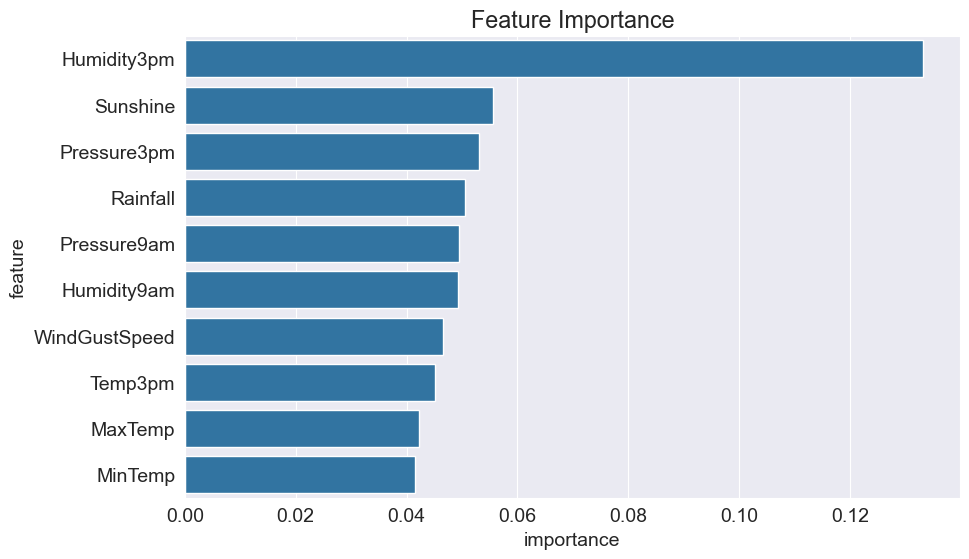

In [69]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x = 'importance', y= 'feature')

In [70]:
%%time
base_model = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_train, train_targets)

CPU times: total: 42.1 s
Wall time: 4.1 s


In [71]:
base_train_acc = base_model.score(X_train, train_targets)
base_val_acc = base_model.score(X_val, val_targets)

In [72]:
base_accs = base_train_acc, base_val_acc
base_accs

(0.9999595910615429, 0.8559572862863444)

In [73]:
%%time
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=10).fit(X_train, train_targets)

CPU times: total: 3.91 s
Wall time: 586 ms


In [74]:
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.9873520022629005, 0.8441761940688295)

In [75]:
base_accs

(0.9999595910615429, 0.8559572862863444)

In [76]:
%%time
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=500)

CPU times: total: 0 ns
Wall time: 4 ms


In [77]:
model.fit(X_train, train_targets)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [78]:
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.9999797955307714, 0.8572920898380825)

In [79]:
def test_params(**params):
    model = RandomForestClassifier(random_state = 42, n_jobs=-1,**params).fit(X_train, train_targets)

    return model.score(X_train, train_targets), model.score(X_val, val_targets)

In [80]:
test_params(max_depth=5)

(0.821847092576878, 0.8262433985259126)

In [81]:
test_params(max_depth=26)

(0.9820685335596234, 0.857001915152922)

In [82]:
test_params(max_leaf_nodes=2**5)

(0.8307572635066877, 0.8324531367883465)

In [83]:
test_params(max_depth=5,max_leaf_nodes=1024,n_estimators=1000)

(0.8221299551460783, 0.8266496430851372)

In [84]:
test_params(max_features='log2')

(0.9999595910615429, 0.8540421333642852)

In [88]:
test_params(min_impurity_decrease=1e-6)

(0.9883420212551016, 0.8568858452788579)

In [89]:
test_params(bootstrap=False)

(0.9999797955307714, 0.8558992513493123)

In [91]:
test_params(max_samples = 0.9)

(0.9997575463692568, 0.8565956705936975)

In [99]:
base_accs

(0.9999595910615429, 0.8559572862863444)

In [93]:
train_targets.value_counts()/len(train_targets)

RainTomorrow
No     0.774892
Yes    0.225108
Name: count, dtype: float64

In [94]:
model.classes_

array(['No', 'Yes'], dtype=object)

In [95]:
test_params(class_weight = 'balanced')

(0.9999494888269285, 0.8556671116011839)

In [96]:
test_params(class_weight={'No':1,'Yes':2})

(0.9999292843576999, 0.8565376356566653)

In [98]:
base_accs

(0.9999595910615429, 0.8559572862863444)

In [104]:
model = RandomForestClassifier(n_jobs=-1,
                              random_state=42,
                              n_estimators=500,
                               max_features=20,
                              max_depth=30,
                              class_weight={'No':1,'Yes':1.5})

In [105]:
model.fit(X_train, train_targets)

,n_estimators,500
,criterion,'gini'
,max_depth,30
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,20
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [106]:
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.9991312078231704, 0.8576402994602751)

In [107]:
base_accs

(0.9999595910615429, 0.8559572862863444)

In [108]:
model.score(X_test, test_targets)

0.8454223454223454

In [116]:
# created seperate function for individual inputs
def predict_input(model,single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols]) 
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])

    X_input = input_df[numeric_cols + encoded_cols]
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]

    return pred, prob
    
    

In [121]:
new_input = {'Date': '2021-06-19',
             'Location': 'Watsonia',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 80.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

In [123]:
predict_input(model,new_input)

C:\Users\MSI\AppData\Local\Temp\ipykernel_18100\2697546321.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\MSI\AppData\Local\Temp\ipykernel_18100\2697546321.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\MSI\AppData\Local\Temp\ipykernel_18100\2697546321.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame,

('Yes', 0.7924058770953226)